# Titanic Dataset
## Binary classification
Analyse the data and classify passengers will survive or not. 

### Data Dictionary


| Variable  | Definition | Key |
|-----------|------------|-----|
| survival  | Survival | 0 = No, 1 = Yes|
| pclass    | Ticket class| 1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex|  |
|Age|Age in years|  |
|sibsp|# of siblings / spouses aboard the Titanic|   |
|parch|# of parents / children aboard the Titanic|   |
|ticket| Ticket number|  |	
|fare| Passenger fare|   |
|cabin| Cabin number|   |
|embarked| Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton| |


### Variable Notes

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pickle
from scipy.stats import t
import math
import seaborn as sns
import logistic_regression as lgr # implemented logistic regression
from sklearn.linear_model import LogisticRegression as lgr2  # logistic regression from scikit learn
from sklearn.model_selection import train_test_split

plt.style.use('mycustomstyle')
%matplotlib inline

In [4]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

____

# Cleaning up the data for analysis

### 1. Dropping the obselete columns

In [5]:
# Pclass has identical information as Fare (higher Plcass will have higher fare). 
# Cabin is given to 1st class passenger and may not impact the outcome 
# PassengerId has info for Name
# Ticket number will not likely affect the survival chances
# Emabrking port should also not impact the survival chances but we will keep it for now to test and discard.
train1 = train.drop(['Name','Ticket','Cabin'], axis=1)
test1 = test.drop(['Name','Ticket','Cabin'], axis=1)


### 2. Null values

In [6]:
# Number of null values in train data
# From: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python
train1.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

#### 2.1 Age variable

C:\Users\login\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\login\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Median age =  28.0 years ; Mode age =  24.0 years


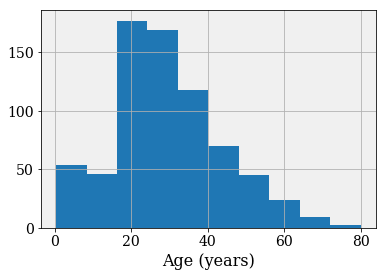

In [7]:
# Visualizing the Age variable
plt.hist(train1['Age'])
plt.xlabel('Age (years)')
median_age = np.nanmedian(train1['Age'])
print('Median age = ',median_age,'years', '; Mode age = ',statistics.mode(train1['Age']),'years')

In [8]:
# Use median age to fill null values
train1['Age'] =train1['Age'].fillna(median_age)
test1['Age'] =test1['Age'].fillna(median_age)
train['Age'] = train['Age'].fillna(median_agen_age)  # helps with data display later

#### 2.2 Embarked variable

S    644
C    168
Q     77
Name: Embarked, dtype: int64


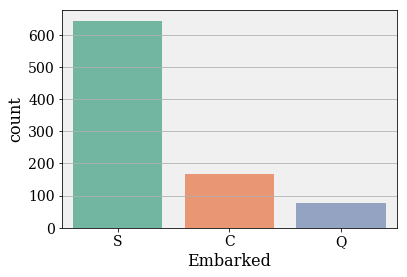

In [10]:
# Visualizing Embarked variable
# From: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python
sns.countplot(x ='Embarked',data =train1, palette ='Set2')
print(train1.Embarked.value_counts())

# Most people embarked from Southampton port. So we will use this for null values.

In [11]:
# Filling null values for Embarked by S
train1.Embarked.fillna(train1.Embarked.value_counts().idxmax(),inplace =True)
test1.Embarked.fillna(train1.Embarked.value_counts().idxmax(),inplace =True)
train.Embarked.fillna(train1.Embarked.value_counts().idxmax(),inplace =True)

In [12]:
# Retesting the null values
train1.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

### 3. Changing Categorical variables to dummy variables for the analysis

In [13]:
# Converting categorical columns to dummy variables
# DO NOT RERUN IF PREVIOUS CELLS HAVE NOT BEEN RERUN

train1['travelAlone'] =  np.multiply(train1['Parch'] ==0,train1['SibSp'] ==0) *1
test1['travelAlone'] =  np.multiply(test1['Parch'] ==0,test1['SibSp'] ==0) *1

train1['gender'] =  (train1.Sex =='male')*1
test1['gender'] =  (test1.Sex =='male')*1

train1 = pd.get_dummies(train1,columns=['Embarked','Pclass'])
test1 = pd.get_dummies(test1, columns = ['Embarked','Pclass'])

# Drop the previous columns
train1.drop(['Sex','SibSp','Parch'],axis=1, inplace =True)
test1.drop(['Sex','SibSp','Parch'],axis=1, inplace =True)

In [14]:
train1.head()

,PassengerId,Survived,Age,Fare,travelAlone,gender,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,22.0,7.2500,0,1,0,0,1,0,0,1
1,2,1,38.0,71.2833,0,0,1,0,0,1,0,0
2,3,1,26.0,7.9250,1,0,0,0,1,0,0,1
3,4,1,35.0,53.1000,0,0,0,0,1,1,0,0
4,5,0,35.0,8.0500,1,1,0,0,1,0,0,1


---------

# Understanding the data

## Plotting the histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC3B9F0FD0>,
      dtype=object)

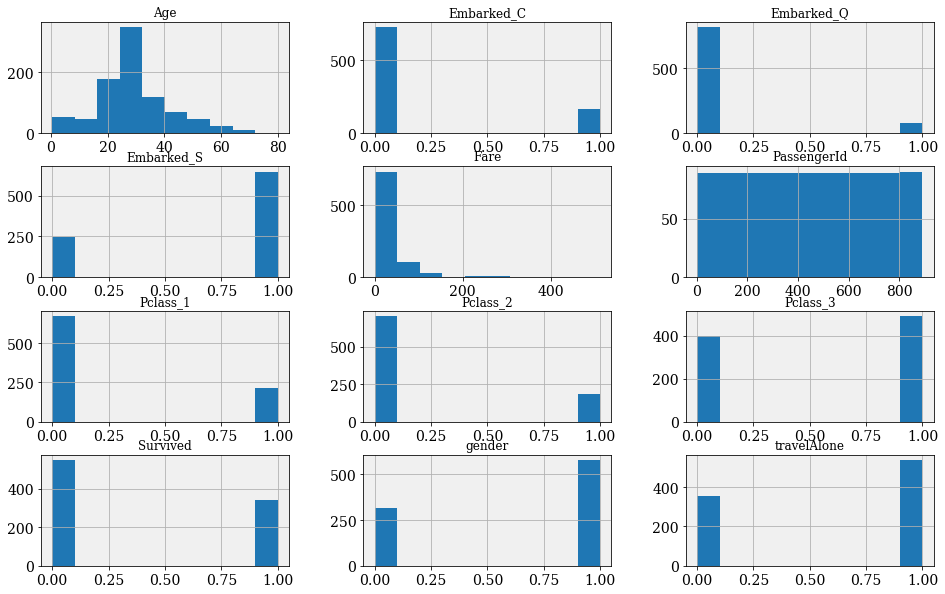

In [12]:
train1.hist(figsize=(16,10))

Doesn't help much!

## Try again

### 1. Age

Analysis from: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python

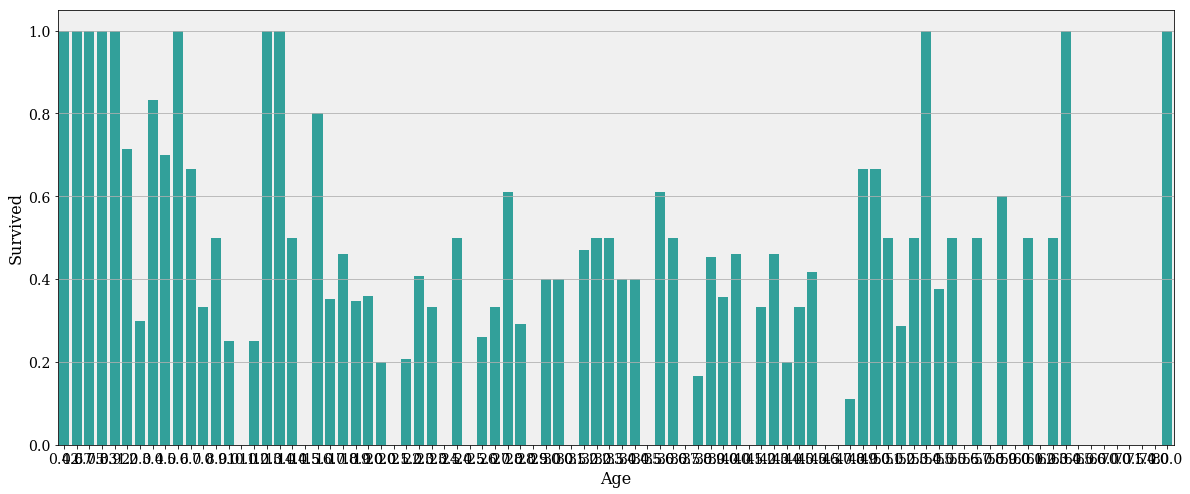

In [15]:
# Age consideration
plt.figure(figsize=(20,8))
avg_survival_byage = train1[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

In [16]:
minor_survival_rate = ((train1.Age<16)*train1.Survived).sum()/(train1.Age<16).sum()
print('The minor (=Age<16) survival rate is:', round(minor_survival_rate*100,1),'%')

nonminor_survival_rate = ((train1.Age>16)*train1.Survived).sum()/(train1.Age>16).sum()
print('The non-minor (=Age>16) survival rate is:', round(nonminor_survival_rate*100,1),'%')

print('Overall survival rate is:', round(100*train1.Survived.sum()/train1.Survived.count(),1),'%')

The minor (=Age<16) survival rate is: 59.0 %
The non-minor (=Age>16) survival rate is: 36.3 %
Overall survival rate is: 38.4 %


 Given the survival rate at younger age, it would be worthwhile to include a variable 'isMinor' with age <16. It pays to analyse the data before doing the modelling.

In [17]:
train1['isMinor'] = (train1['Age']<16.0)*1
test1['isMinor'] = (test1['Age']<16.0)*1
train1.head()

,PassengerId,Survived,Age,Fare,travelAlone,gender,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,isMinor
0,1,0,22.0,7.2500,0,1,0,0,1,0,0,1,0
1,2,1,38.0,71.2833,0,0,1,0,0,1,0,0,0
2,3,1,26.0,7.9250,1,0,0,0,1,0,0,1,0
3,4,1,35.0,53.1000,0,0,0,0,1,1,0,0,0
4,5,0,35.0,8.0500,1,1,0,0,1,0,0,1,0


## 2. Fare

### 2.1 Survival rate as function of Fare

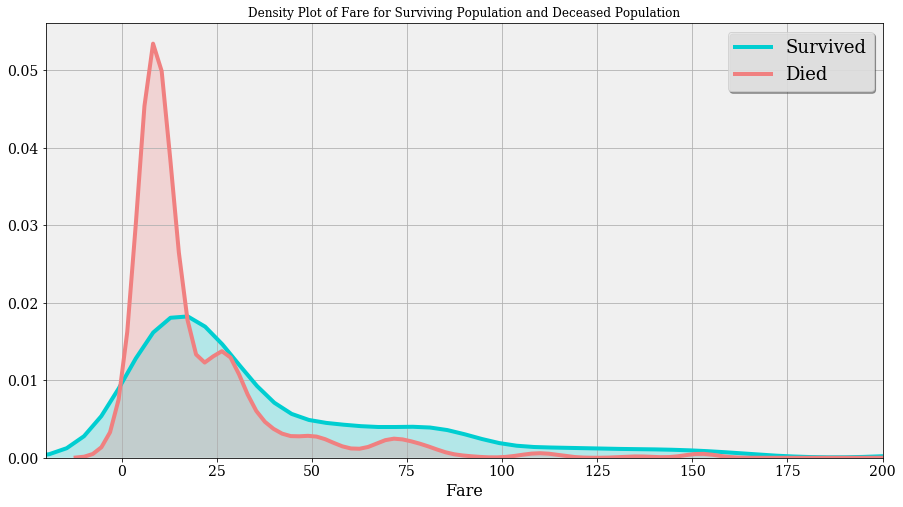

In [19]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train1["Fare"][train1.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(train1["Fare"][train1.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

### 2.2 Pclass as function of Fare

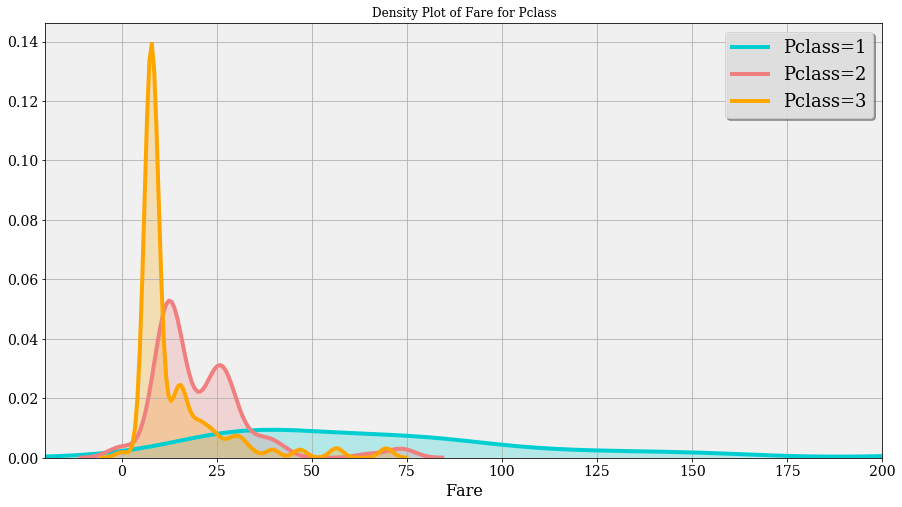

In [20]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train1["Fare"][train1.Pclass_1 == 1], color="darkturquoise", shade=True)
sns.kdeplot(train1["Fare"][train1.Pclass_2 == 1], color="lightcoral", shade=True)
sns.kdeplot(train1["Fare"][train1.Pclass_3 == 1], color="orange", shade=True)

plt.legend(['Pclass=1', 'Pclass=2','Pclass=3'])
plt.title('Density Plot of Fare for Pclass')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

One would have assumed that different passenger class would have different fare bands but apparently, that's not the case. While the Pclass=3 has lowest fare mode, it certainly has some high fares. Pclass=1 distribution is quite evenly distributed across the fare range. It make sense to keep this variable along with Pclass.

### 3. Passenger Class

Same as before

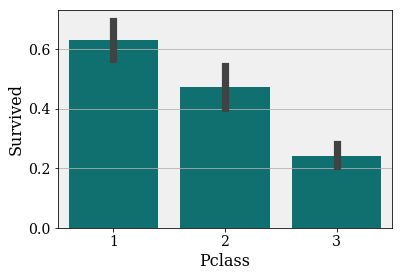

In [21]:
sns.barplot('Pclass','Survived',data =train,color ='teal')
plt.show()

### 4. Embarked Port

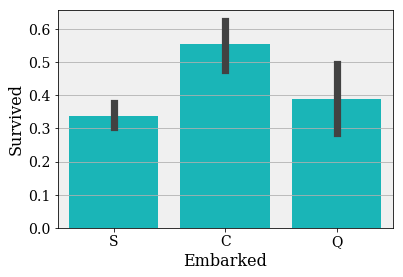

In [22]:
sns.barplot('Embarked','Survived',data=train, color= 'darkturquoise')
plt.show()

 This shows the people who boarded from Cherbroug, France had higher survival rate

In [26]:
train.head()
train['Pclass'].unique()

array([3, 1, 2], dtype=int64)

In [32]:
Embark_C_Pclass_1 = np.multiply(train1["Pclass_1"],train1['Embarked_C']).sum()
Embark_C_Pclass_2 = np.multiply(train1["Pclass_2"],train1['Embarked_C']).sum()
Embark_C_Pclass_3 = np.multiply(train1["Pclass_3"],train1['Embarked_C']).sum()
print('Passenger class for people embarked at Cherbroug')
print('Pclass=1: ',Embark_C_Pclass_1, 'passengers, ', int(100* (Embark_C_Pclass_1/(Embark_C_Pclass_1+Embark_C_Pclass_2+Embark_C_Pclass_3))),'%')
print('Pclass=2: ', Embark_C_Pclass_2, 'passengers, ', int(100* (Embark_C_Pclass_2/(Embark_C_Pclass_1+Embark_C_Pclass_2+Embark_C_Pclass_3))),'%')
print('Pclass=3: ',Embark_C_Pclass_3, 'passengers, ', int(100* (Embark_C_Pclass_3/(Embark_C_Pclass_1+Embark_C_Pclass_2+Embark_C_Pclass_3))),'%')

Embark_S_Pclass_1 = np.multiply(train1["Pclass_1"],train1['Embarked_S']).sum()
Embark_S_Pclass_2 = np.multiply(train1["Pclass_2"],train1['Embarked_S']).sum()
Embark_S_Pclass_3 = np.multiply(train1["Pclass_3"],train1['Embarked_S']).sum()
print('Passenger class for people embarked at Southampton')
print('Pclass=1: ',Embark_S_Pclass_1, 'passengers, ', int(100* (Embark_S_Pclass_1/(Embark_S_Pclass_1+Embark_S_Pclass_2+Embark_S_Pclass_3))),'%')
print('Pclass=2: ', Embark_S_Pclass_2, 'passengers, ', int(100* (Embark_S_Pclass_2/(Embark_S_Pclass_1+Embark_S_Pclass_2+Embark_S_Pclass_3))),'%')
print('Pclass=3: ',Embark_S_Pclass_3, 'passengers, ', int(100* (Embark_S_Pclass_3/(Embark_S_Pclass_1+Embark_S_Pclass_2+Embark_S_Pclass_3))),'%')

Embark_Q_Pclass_1 = np.multiply(train1["Pclass_1"],train1['Embarked_Q']).sum()
Embark_Q_Pclass_2 = np.multiply(train1["Pclass_2"],train1['Embarked_Q']).sum()
Embark_Q_Pclass_3 = np.multiply(train1["Pclass_3"],train1['Embarked_Q']).sum()
print('Passenger class for people embarked at Q')
print('Pclass=1: ',Embark_Q_Pclass_1, 'passengers, ', int(100* (Embark_Q_Pclass_1/(Embark_Q_Pclass_1+Embark_Q_Pclass_2+Embark_Q_Pclass_3))),'%')
print('Pclass=2: ', Embark_Q_Pclass_2, 'passengers, ', int(100* (Embark_Q_Pclass_2/(Embark_Q_Pclass_1+Embark_Q_Pclass_2+Embark_Q_Pclass_3))),'%')
print('Pclass=3: ',Embark_Q_Pclass_3, 'passengers, ', int(100* (Embark_Q_Pclass_3/(Embark_Q_Pclass_1+Embark_Q_Pclass_2+Embark_Q_Pclass_3))),'%')

Passenger class for people embarked at Cherbroug
Pclass=1:  85 passengers,  50 %
Pclass=2:  17 passengers,  10 %
Pclass=3:  66 passengers,  39 %
Passenger class for people embarked at Southampton
Pclass=1:  129 passengers,  19 %
Pclass=2:  164 passengers,  25 %
Pclass=3:  353 passengers,  54 %
Passenger class for people embarked at Q
Pclass=1:  2 passengers,  2 %
Pclass=2:  3 passengers,  3 %
Pclass=3:  72 passengers,  93 %


Majority of people who embarked in Cherbroug were in Passenger class 1

In [33]:
Survival_Embark_C_Pclass_1 = np.multiply(np.multiply(train1["Pclass_1"],train1['Embarked_C']),train1.Survived).sum()
Survival_Embark_C_Pclass_2 = np.multiply(np.multiply(train1["Pclass_2"],train1['Embarked_C']),train1.Survived).sum()
Survival_Embark_C_Pclass_3 = np.multiply(np.multiply(train1["Pclass_3"],train1['Embarked_C']),train1.Survived).sum()

print('Survival rate for people embarked at Cherbroug as per the Passenger class')
print(Survival_Embark_C_Pclass_1,'people survived in Pclass=1 out of ',Embark_C_Pclass_1, 'passengers, ', 100*Survival_Embark_C_Pclass_1/Embark_C_Pclass_1)
print(Survival_Embark_C_Pclass_2,'people survived in Pclass=2 out of ',Embark_C_Pclass_2, 'passengers, ', 100*Survival_Embark_C_Pclass_2/Embark_C_Pclass_2)
print(Survival_Embark_C_Pclass_3,'people survived in Pclass=3 out of ',Embark_C_Pclass_3, 'passengers, ', 100*Survival_Embark_C_Pclass_3/Embark_C_Pclass_3)


Survival_Embark_S_Pclass_1 = np.multiply(np.multiply(train1["Pclass_1"],train1['Embarked_S']),train1.Survived).sum()
Survival_Embark_S_Pclass_2 = np.multiply(np.multiply(train1["Pclass_2"],train1['Embarked_S']),train1.Survived).sum()
Survival_Embark_S_Pclass_3 = np.multiply(np.multiply(train1["Pclass_3"],train1['Embarked_S']),train1.Survived).sum()

print('Survival rate for people embarked at Chouthampton as per the Passenger class')
print(Survival_Embark_S_Pclass_1,'people survived in Pclass=1 out of ',Embark_S_Pclass_1, 'passengers, ', 100*Survival_Embark_S_Pclass_1/Embark_S_Pclass_1)
print(Survival_Embark_S_Pclass_2,'people survived in Pclass=2 out of ',Embark_S_Pclass_2, 'passengers, ', 100*Survival_Embark_S_Pclass_2/Embark_S_Pclass_2)
print(Survival_Embark_S_Pclass_3,'people survived in Pclass=3 out of ',Embark_S_Pclass_3, 'passengers, ', 100*Survival_Embark_S_Pclass_3/Embark_S_Pclass_3)

Survival rate for people embarked at Cherbroug as per the Passenger class
59 people survived in Pclass=1 out of  85 passengers,  69.41176470588235
9 people survived in Pclass=2 out of  17 passengers,  52.94117647058823
25 people survived in Pclass=3 out of  66 passengers,  37.878787878787875
Survival rate for people embarked at Chouthampton as per the Passenger class
76 people survived in Pclass=1 out of  129 passengers,  58.91472868217054
76 people survived in Pclass=2 out of  164 passengers,  46.34146341463415
67 people survived in Pclass=3 out of  353 passengers,  18.980169971671387


### 5. Travelling alone

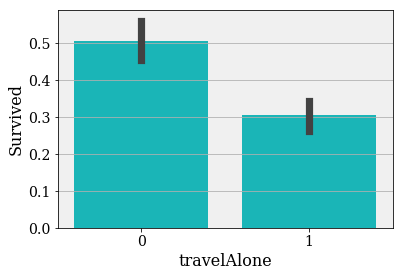

In [35]:
sns.barplot('travelAlone','Survived',data=train1, color= 'darkturquoise')
plt.show()

People who travelled alone had a higher chance of survival

### 6. Gender

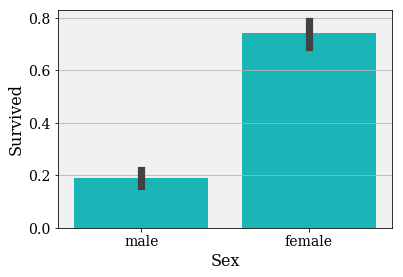

In [36]:
sns.barplot('Sex','Survived',data=train, color= 'darkturquoise')
plt.show()

Higher chance of survival for female 

--------

# Classifications

## 1. Logistic Regression
### 1.1 Implemented Logistic Regression

<font color ='red'>
**Check how normalizing Age and Fare will impact the logistic regression results** 
</fontcolor>

In [37]:
# import implemented logistic regression
train_X = train1.iloc[:,2:]
test_X = test1.iloc[:,1:]
train_Y = train1.iloc[:,1:2]


### Crossvalidation set logic
As we do not have enough data to create a proper cross-validation set, we run the model _n_ number of times with randomly chosen cross-validation set of 10% data (about 81 data points for each iteration). We can then analyze the statistical distribution of parameters as well as test accuracy (or some other) metrics. This statistical distribution can be compared to different experiments we may want to work on such as dropping number of features.  

In [40]:
# Run the model n times
n =100
model ={}
train_index = {}
test_index = {}
for i in range(n):
    X_train, X_CV, y_train, y_CV = train_test_split(train_X, train_Y,test_size=0.1)
    train_index[i] = X_train.index.tolist() 
    cv_index[i] = X_CV.index.tolist()
    print('Iteration number: ', i, 'out of ',n)
    model[i] = lgr.model(X_train.T,np.array(y_train.T),  X_CV.T, np.array(y_CV.T), num_iterations = 25000, 
                         learning_rate = 0.005, print_cost = False)

Iteration number:  0 out of  100
train accuracy: 81.27340823970037 %
test accuracy: 77.77777777777777 %
Iteration number:  1 out of  100
train accuracy: 81.02372034956305 %
test accuracy: 78.88888888888889 %
Iteration number:  2 out of  100
train accuracy: 80.77403245942571 %
test accuracy: 84.44444444444444 %
Iteration number:  3 out of  100
train accuracy: 81.02372034956305 %
test accuracy: 83.33333333333334 %
Iteration number:  4 out of  100
train accuracy: 80.39950062421973 %
test accuracy: 85.55555555555556 %
Iteration number:  5 out of  100
train accuracy: 80.52434456928839 %
test accuracy: 84.44444444444444 %
Iteration number:  6 out of  100
train accuracy: 80.77403245942571 %
test accuracy: 77.77777777777777 %
Iteration number:  7 out of  100
train accuracy: 80.27465667915106 %
test accuracy: 80.0 %
Iteration number:  8 out of  100
train accuracy: 80.02496878901374 %
test accuracy: 82.22222222222223 %
Iteration number:  9 out of  100
train accuracy: 80.39950062421973 %
test acc

train accuracy: 80.89887640449439 %
test accuracy: 76.66666666666667 %
Iteration number:  80 out of  100
train accuracy: 80.89887640449439 %
test accuracy: 75.55555555555556 %
Iteration number:  81 out of  100
train accuracy: 80.39950062421973 %
test accuracy: 75.55555555555556 %
Iteration number:  82 out of  100
train accuracy: 80.64918851435705 %
test accuracy: 77.77777777777777 %
Iteration number:  83 out of  100
train accuracy: 80.52434456928839 %
test accuracy: 80.0 %
Iteration number:  84 out of  100
train accuracy: 80.64918851435705 %
test accuracy: 82.22222222222223 %
Iteration number:  85 out of  100
train accuracy: 80.77403245942571 %
test accuracy: 77.77777777777777 %
Iteration number:  86 out of  100
train accuracy: 81.64794007490636 %
test accuracy: 73.33333333333333 %
Iteration number:  87 out of  100
train accuracy: 81.27340823970037 %
test accuracy: 77.77777777777777 %
Iteration number:  88 out of  100
train accuracy: 81.39825218476904 %
test accuracy: 74.44444444444444

In [68]:
# Exporting pickle
dictionary = {'model':model, 'train_index': train_index, 'cv_index':cv_index}
# t = dictionary['train_index']
# t[0]
pickle_out =open('Titanic_impl_lgr_run100_dict.pickle','wb')
pickle.dump(dictionary,pickle_out)
pickle_out.close()

In [ ]:
# import pickle
# pickle_in = open('Titanic_impllgr_run100_dict.pickle','rb')
# model = pickle.load(pickle_in)

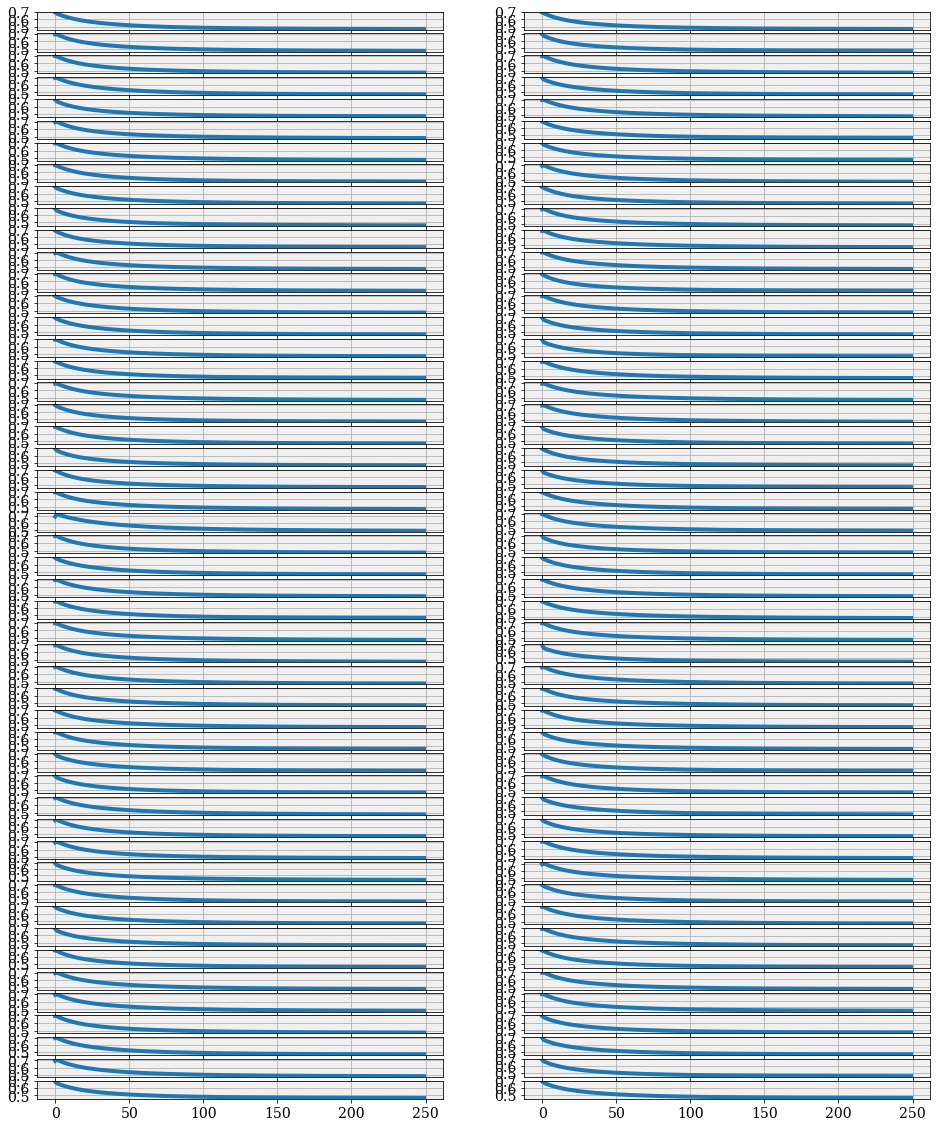

In [35]:
# Check cost functions
# plt.figure(figsize=(16,20))
# for i in range(n):
#     plt.subplot(int(n/2),2,i+1)
#     plt.plot(model[i]['costs'])

Mean Train accuracy is:  80.60174781523096 and SD is: 0.8591186673161284
Mean Cross-validation accuracy is:  79.9 and SD is: 4.000293199130828
Median Cross-validation accuracy is:  80.0


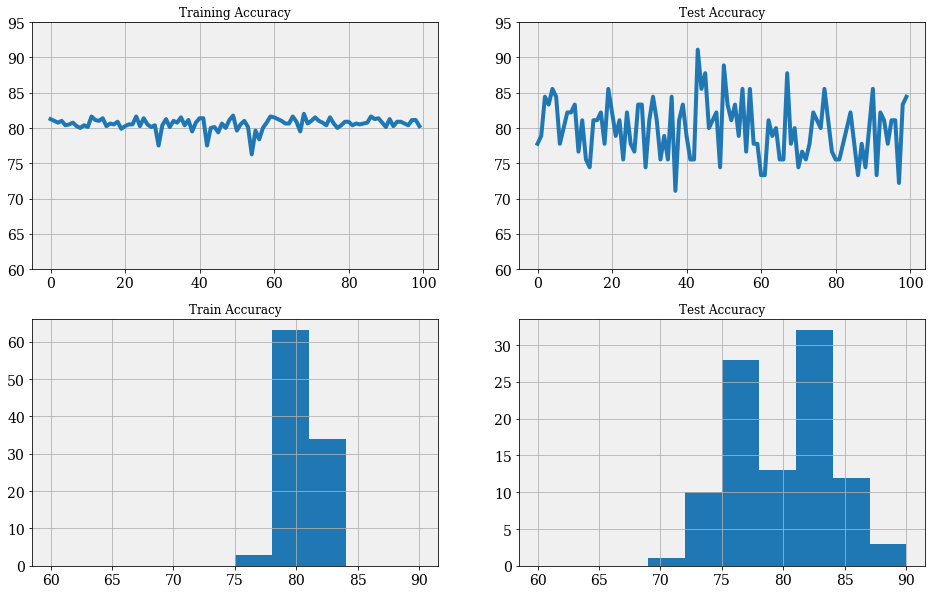

In [44]:
plt.figure(figsize=(16,10))
train_acc= []
test_acc = []
for i in range(n):
    train_acc.append(model[i]['train_accuracy'])
    test_acc.append(model[i]['test_accuracy'])

plt.subplot(2,2,1)
plt.plot(train_acc)
plt.ylim([60,95])
plt.title('Training Accuracy')

plt.subplot(2,2,2)
plt.plot(test_acc)
plt.ylim([60,95])
plt.title('Test Accuracy')

plt.subplot(2,2,3)
plt.hist(train_acc, range = [60,90])
plt.title('Train Accuracy')

plt.subplot(2,2,4)
plt.hist(test_acc,range = [60,90])
plt.title('Test Accuracy')

print('Mean Train accuracy is: ', np.mean(train_acc), 'and SD is:', np.std(train_acc))
print('Mean Cross-validation accuracy is: ', np.mean(test_acc), 'and SD is:', np.std(test_acc))
print('Median Cross-validation accuracy is: ', np.median(test_acc))

                 Mean  Std. Dev       CI1       CI2  Probability of Survival
Age         -0.023678  0.003226 -0.029034 -0.018322                49.408068
Fare        -0.000970  0.004250 -0.008027  0.006087                49.975754
travelAlone  0.342954  0.062687  0.238869  0.447039                58.490797
gender      -2.596158  0.063378 -2.701391 -2.490926                 6.938607
Embarked_C   0.548441  0.055093  0.456966  0.639916                63.377379
Embarked_Q   0.393161  0.060359  0.292942  0.493380                59.704330
Embarked_S  -0.014399  0.044987 -0.089095  0.060297                49.640032
Pclass_1     1.070394  0.053879  0.980934  1.159853                74.467179
Pclass_2     0.533327  0.046867  0.455510  0.611144                63.025870
Pclass_3    -0.676518  0.036336 -0.736851 -0.616185                33.703887
isMinor      0.736163  0.072767  0.615342  0.856984                67.615624


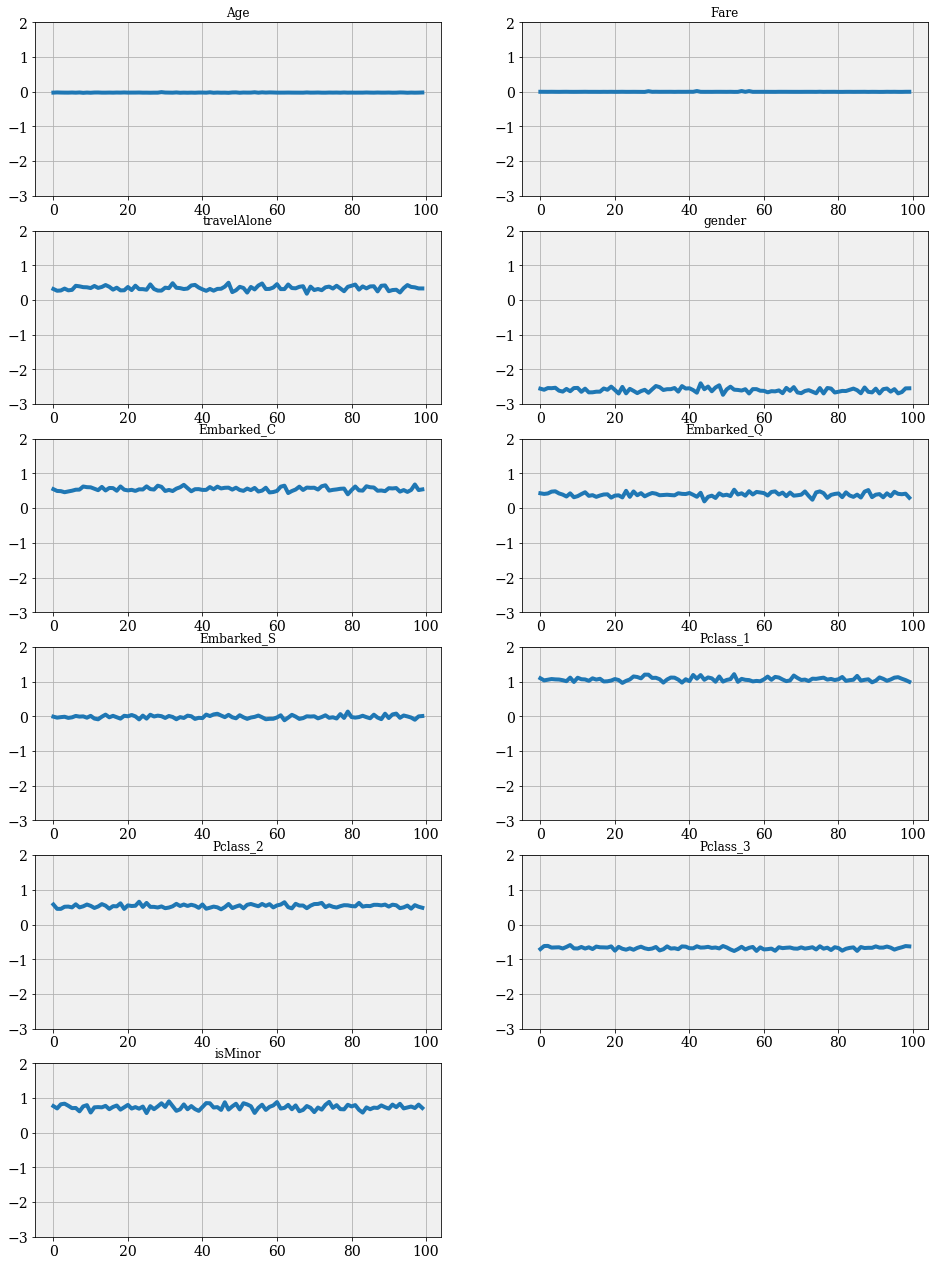

In [46]:
df_w = pd.DataFrame()
df_b = []
for i in range(n):
    df_b.append(model[i]['b'])
    data = pd.DataFrame.from_records(model[i]['w'])
    df_w = pd.concat([df_w,data],axis=1)

df_w = df_w.T
df_w.columns = X_train.columns
df_w = df_w.reset_index(drop=True)

summary = pd.DataFrame()
summary['Mean'] = df_w.mean()
summary['Std. Dev'] = df_w.std()
n= len(df_w.Age)
summary['CI1'] = df_w.mean() - t.ppf([0.95],n-1)*df_w.std()  # T-test for 95% confidence interval
summary['CI2'] = df_w.mean() + t.ppf([0.95],n-1)*df_w.std()  # T-test for 95% confidence interval
summary['Probability of Survival'] = 100*(np.exp(summary.Mean))/(1+ np.exp(summary.Mean))
print(summary)

plt.figure(figsize =(16,30))
c =1
for i in df_w:
        plt.subplot(8,2,c)
        plt.plot(df_w[i])
        plt.title(i)
        plt.ylim([-3, 2])
        c+=1


### Observations
- Note the parameters for age and fare variables are quite small (nearly zero) with small variance compared to other variables. This might be due to the  different value range for Age and Fare. While all the other variables are categorical, Age and Fare are not. Normalizing these variables with mean 0 and std dev 1 may help.

- Out of other variabels, Gender (female having an advantage on survival rate) seems to have highest impact on classification, followed by Pclass 1.


- Problem is to figure out whether a passenger survived. The coefficients of logistic regression gives odds (or indirectly probability) of that happening based on the variable under cosnideration. This can be evaluated as:
$Probability(Survival) = e^c/(1+e^c)$, where c is coeff of variable

- Confidence interval indicates if c is significantly different than 0 or if probability of survival is better than 50-50 chance which is same as flipping a coin instead of using the variable under consideration. In essence, a coefficient that is not significantly different from 0 will indicate that the variable is not very informative and may be excluded from the model.   
- Confidence interval indicates that Fare and Embarked_S do not have siginificant contribution to classification (can we use CI for classification?) as they consist of 0 within this interval.  The probability of survival based on each variable is also calcualted. Age, Fare and Embarked_S variables are very close to 50-50 chance. Need to see how the model works if drop these terms.  

In [34]:
print('Max Age: ',max(train1.Age),'| Min Age:',min(train1.Age))
print('Max Fare: ',max(train1.Fare),'| Min Fare:',min(train1.Fare))

Max Age:  80.0 | Min Age: 0.42
Max Fare:  512.3292 | Min Fare: 0.0


## Normalizing variables

Text(0.5, 1.0, 'Fare')

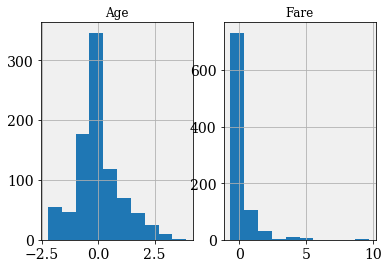

In [76]:
# import implemented logistic regression with normalized age and fare
# train_X = train1.iloc[:,2:]

# test_X = test1.iloc[:,1:]
# train_Y = train1.iloc[:,1:2]
train_X.Age = (train_X.Age - np.mean(train_X.Age))/np.std(train_X.Age)
train_X.Fare = (train_X.Fare - np.mean(train_X.Fare))/np.std(train_X.Fare)

plt.Figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.hist(train_X.Age)
plt.title('Age')
plt.subplot(1,2,2)
plt.hist(train_X.Fare)
plt.title('Fare')

In [77]:
n =100
model_norm ={}
for i in range(n):
    # Splitting the training set in 
    X_train = train_X.iloc[train_index[i]]
    y_train = train_Y.iloc[train_index[i]]
    X_CV = train_X.iloc[cv_index[i]]
    y_CV = train_Y.iloc[cv_index[i]]
    print('Iteration number: ', i, 'out of ',n)
    model_norm[i] = lgr.model(X_train.T,np.array(y_train.T),  X_CV.T, np.array(y_CV.T), num_iterations = 25000, 
                         learning_rate = 0.005, print_cost = False)

Iteration number:  0 out of  100
train accuracy: 80.64918851435705 %
test accuracy: 78.88888888888889 %
Iteration number:  1 out of  100
train accuracy: 79.7752808988764 %
test accuracy: 77.77777777777777 %
Iteration number:  2 out of  100
train accuracy: 79.52559300873908 %
test accuracy: 80.0 %
Iteration number:  3 out of  100
train accuracy: 80.77403245942571 %
test accuracy: 78.88888888888889 %
Iteration number:  4 out of  100
train accuracy: 80.52434456928839 %
test accuracy: 84.44444444444444 %
Iteration number:  5 out of  100
train accuracy: 79.7752808988764 %
test accuracy: 81.11111111111111 %
Iteration number:  6 out of  100
train accuracy: 80.39950062421973 %
test accuracy: 76.66666666666667 %
Iteration number:  7 out of  100
train accuracy: 79.65043695380774 %
test accuracy: 78.88888888888889 %
Iteration number:  8 out of  100
train accuracy: 80.39950062421973 %
test accuracy: 78.88888888888889 %
Iteration number:  9 out of  100
train accuracy: 79.90012484394506 %
test accur

train accuracy: 80.39950062421973 %
test accuracy: 76.66666666666667 %
Iteration number:  80 out of  100
train accuracy: 80.39950062421973 %
test accuracy: 80.0 %
Iteration number:  81 out of  100
train accuracy: 81.14856429463171 %
test accuracy: 76.66666666666667 %
Iteration number:  82 out of  100
train accuracy: 79.90012484394506 %
test accuracy: 80.0 %
Iteration number:  83 out of  100
train accuracy: 79.7752808988764 %
test accuracy: 82.22222222222223 %
Iteration number:  84 out of  100
train accuracy: 79.7752808988764 %
test accuracy: 82.22222222222223 %
Iteration number:  85 out of  100
train accuracy: 81.52309612983771 %
test accuracy: 76.66666666666667 %
Iteration number:  86 out of  100
train accuracy: 80.64918851435705 %
test accuracy: 74.44444444444444 %
Iteration number:  87 out of  100
train accuracy: 80.14981273408239 %
test accuracy: 78.88888888888889 %
Iteration number:  88 out of  100
train accuracy: 80.64918851435705 %
test accuracy: 76.66666666666667 %
Iteration nu

In [79]:
dictionary = {'model_norm':model_norm, 'train_index': train_index, 'cv_index':cv_index}
# train = dictionary['train_index']
# train[0]
pickle_out =open('Titanic_impl_lgr_run100_dict_norm.pickle','wb')
pickle.dump(dictionary,pickle_out)
pickle_out.close()

In [79]:
# pickle_in = open('Titanic_impl_lgr_run100_dict_norm.pickle','rb')
# model_norm = pickle.load(pickle_in)

Mean Train accuracy is:  80.30586766541823 and SD is: 0.6167783671750809
Mean Cross-validation accuracy is:  79.32222222222222 and SD is: 4.1272805143877065
Median Cross-validation accuracy is:  78.88888888888889


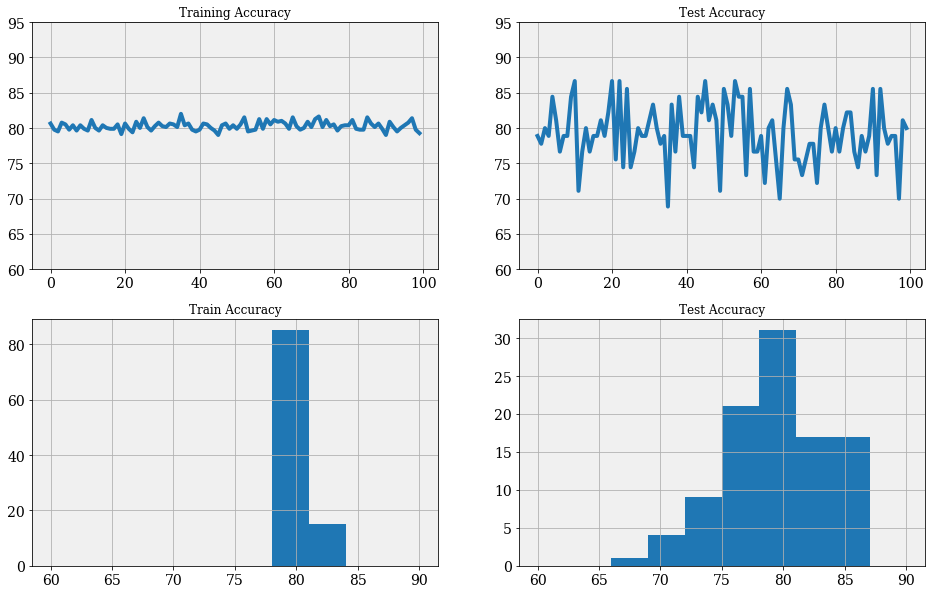

In [78]:
plt.figure(figsize=(16,10))
train_acc= []
test_acc = []
for i in range(n):
    train_acc.append(model_norm[i]['train_accuracy'])
    test_acc.append(model_norm[i]['test_accuracy'])

plt.subplot(2,2,1)
plt.plot(train_acc)
plt.ylim([60,95])
plt.title('Training Accuracy')

plt.subplot(2,2,2)
plt.plot(test_acc)
plt.ylim([60,95])
plt.title('Test Accuracy')

plt.subplot(2,2,3)
plt.hist(train_acc, range = [60,90])
plt.title('Train Accuracy')

plt.subplot(2,2,4)
plt.hist(test_acc,range = [60,90])
plt.title('Test Accuracy')

print('Mean Train accuracy is: ', np.mean(train_acc), 'and SD is:', np.std(train_acc))
print('Mean Cross-validation accuracy is: ', np.mean(test_acc), 'and SD is:', np.std(test_acc))
print('Median Cross-validation accuracy is: ', np.median(test_acc))

In [80]:
df_w = pd.DataFrame()
df_b = []
for i in range(n):
    df_b.append(model_norm[i]['b'])
    data = pd.DataFrame.from_records(model_norm[i]['w'])
    df_w = pd.concat([df_w,data],axis=1)

df_w = df_w.T
df_w.columns = X_train.columns
df_w = df_w.reset_index(drop=True)

summary = pd.DataFrame()
summary['Mean'] = df_w.mean()
summary['Std. Dev'] = df_w.std()
n= len(df_w.Age)
summary['CI1'] = df_w.mean() - t.ppf([0.95],n-1)*df_w.std()  # T-test for 95% confidence interval
summary['CI2'] = df_w.mean() + t.ppf([0.95],n-1)*df_w.std()  # T-test for 95% confidence interval
summary['Probability of Survival'] = 100*(np.exp(summary.Mean))/(1+ np.exp(summary.Mean))

summary['Probability of Survival CI1'] = 100*(np.exp(summary.CI1))/(1+ np.exp(summary.CI1))
summary['Probability of Survival CI2'] = 100*(np.exp(summary.CI2))/(1+ np.exp(summary.CI2))
summary


,Mean,Std. Dev,CI1,CI2,Probability of Survival,Probability of Survival CI1,Probability of Survival CI2
Age,-0.306681,0.032029,-0.359861,-0.253500,42.392516,41.099317,43.696219
Fare,0.062019,0.031819,0.009187,0.114851,51.549983,50.229677,52.868129
travelAlone,0.142111,0.054656,0.051361,0.232860,53.546796,51.283736,55.795343
gender,-2.490905,0.054029,-2.580615,-2.401195,7.649825,7.039650,8.308161
Embarked_C,0.484058,0.047953,0.404437,0.563679,61.870569,59.975332,63.730334
Embarked_Q,0.391450,0.061691,0.289020,0.493881,59.663180,57.175610,62.102030
Embarked_S,-0.058244,0.038174,-0.121627,0.005140,48.544314,46.963057,50.128491
Pclass_1,1.218938,0.046295,1.142070,1.295806,77.187655,75.805944,78.512823
Pclass_2,0.432742,0.043910,0.359833,0.505650,60.652817,58.900007,62.378621
Pclass_3,-0.834415,0.037698,-0.897009,-0.771821,30.271241,28.966557,31.608540


Age            0.001026
Fare           0.001012
travelAlone    0.002987
gender         0.002919
Embarked_C     0.002299
Embarked_Q     0.003806
Embarked_S     0.001457
Pclass_1       0.002143
Pclass_2       0.001928
Pclass_3       0.001421
isMinor        0.005157
dtype: float64


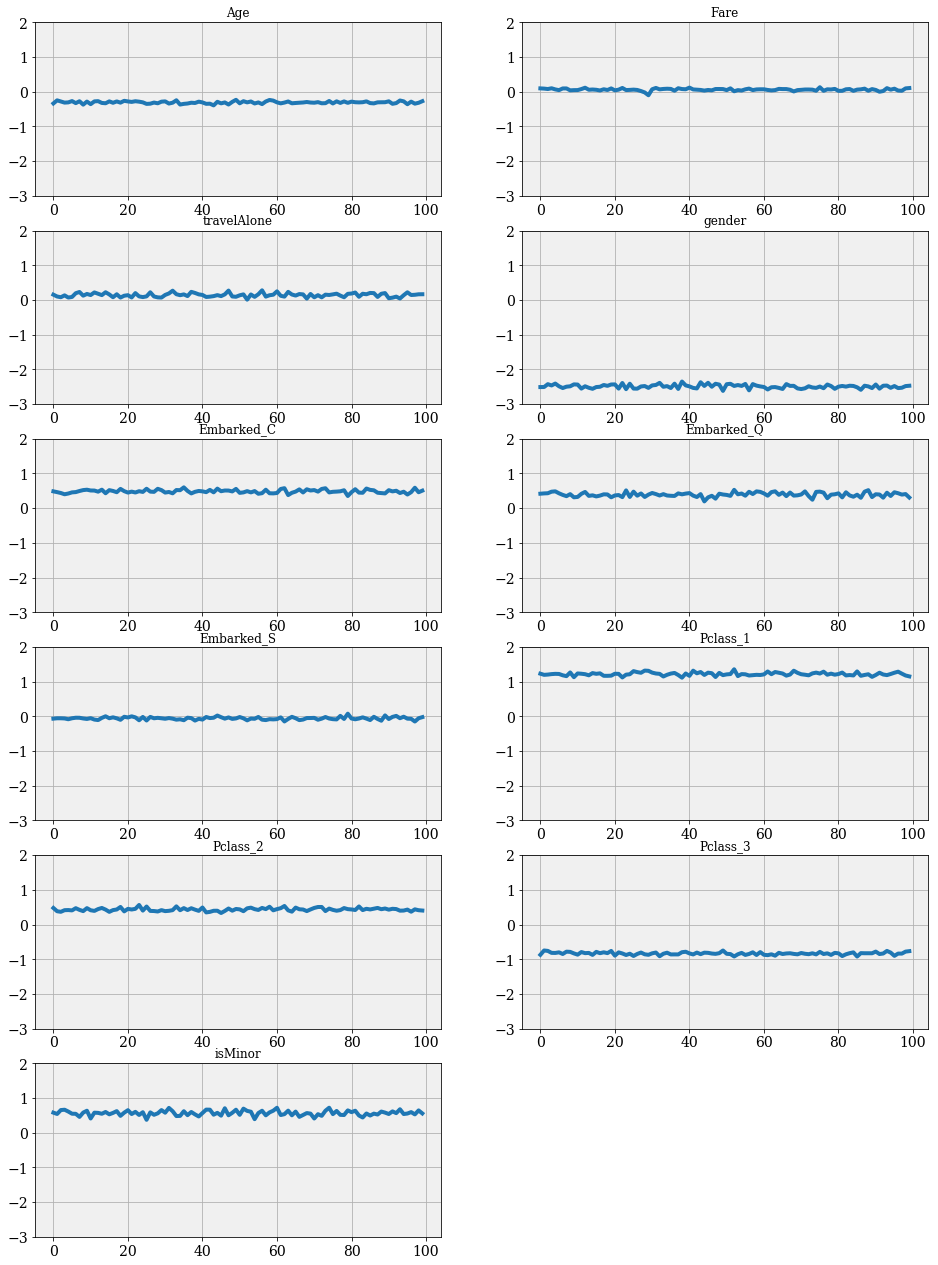

In [81]:

print(df_w.var())
plt.figure(figsize =(16,30))
c =1
for i in df_w:
        plt.subplot(8,2,c)
        plt.plot(df_w[i])
        plt.title(i)
        plt.ylim([-3, 2])
        c+=1

### Observation

- While the Fare and Embarked_S probability is different from 50% now, the CI still contains 50% in the interval. 

In [101]:
median_age = np.nanmedian(train['Age'])
train['Age'].fillna(median_age, inplace=True)


<Figure size 720x720 with 0 Axes>

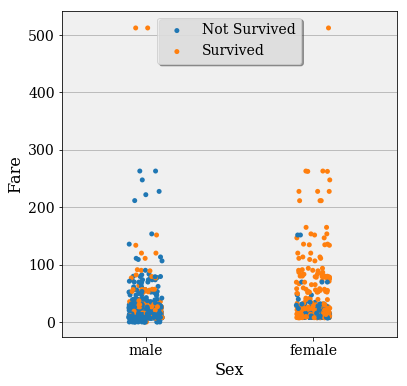

In [130]:
plt.figure(figsize=(10,10))
# sb.scatterplot(train1.Age, train1.Pclass_1, hue =train1.Survived)
# plt.subplot(2,2,1)
# sb.stripplot(train.Embarked, train.Pclass, hue = train.Survived)
# plt.legend(loc='best')

plt.figure(figsize=(6,6))
# plt.subplot(2,2,2)
sb.stripplot(train.Sex, train.Fare, hue = train.Survived)
plt.legend(['Not Survived','Survived'],loc='best', fontsize =14)

# plt.subplot(2,2,3)
# sb.stripplot(train.Sex, train.Fare, hue = train.Survived)
# plt.legend(loc='best')

### 1.2 Scikit Logistic Regression

#### Feature Selection

Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

References: 
http://scikit-learn.org/stable/modules/feature_selection.html 

In [164]:
train_X = train1.iloc[:,2:]
test_X = test1.iloc[:,1:]
train_Y = train1.iloc[:,1:2]
train_Y = np.ravel(train_Y)

model2 = lgr2(tol = 1e-6,solver='lbfgs',max_iter =10000).fit(train_X,train_Y)
test2_Y = model2.predict(test_X)
print(model2.score(train_X,train_Y)*100)


79.2368125701459


#### 1.2.1 Parameter Testing: Solver

## 2. SVM

## 3. Random Forest

In [75]:
dat = pd.DataFrame(test2_Y,columns=['Survived'])
df = pd.concat([test,dat],axis=1)
# 
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [85]:
df2 = df[['PassengerId','Survived']]
df2.to_csv('Test_Y.csv')